In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
! ls data/

strong_fft_n=128000000_p=64_11077776 weak_fft_n=512000000_p=64_11077797
strong_fft_n=128000000_p=64_11077778 weak_fft_n=512000000_p=64_11077800
weak_fft_n=512000000_p=64_11077796


In [3]:
df0 = pd.read_csv('data/strong_fft_n=128000000_p=64_11077776/strong_fft_n=128000000_p=64_11077776.csv')
df1 = pd.read_csv('data/strong_fft_n=128000000_p=64_11077778/strong_fft_n=128000000_p=64_11077778.csv')

In [4]:
n_points = df0.groupby('experiment_id')[['n_points']].sum()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def strong_scaling(dfs, names=None, title="Strong Scaling and Parallel Efficiency"):
    """
    Plots strong scaling (runtime) and parallel efficiency for one or more DataFrames.

    Parameters
    ----------
    dfs : list of pandas.DataFrame or pandas.DataFrame
        One or more DataFrames with columns including:
        ['experiment_id', 'runtime', 'p2m', 'm2l', 'm2m', 'l2l', 'source_tree', 'n_points', 'source_local_trees_per_rank']
    names : list of str, optional
        Names/labels for each DataFrame. Must be same length as dfs.
    title : str
        Title for the figure.
    """

    # Handle single DataFrame input
    if not isinstance(dfs, (list, tuple)):
        dfs = [dfs]
    if names is None:
        names = [f"Run {i+1}" for i in range(len(dfs))]

    # Style setup
    sns.set_context("talk", font_scale=1.1)
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    ax_runtime, ax_eff = axes

    # Marker and color configuration
    markers = ['o', 's', '^', 'D', 'v', 'P', '*']
    colors = sns.color_palette("deep", len(dfs))

    for df, label, color, marker in zip(dfs, names, colors, markers):
        stats = df.groupby('experiment_id')[['runtime', 'p2m', 'm2l', 'm2m', 'l2l', 'source_tree', 'n_points', 'source_local_trees_per_rank']]
        n_ranks = stats.size()
        runtime = stats.mean()['runtime']
        runtime_err = stats.std()['runtime']

        # Ideal scaling
        T1 = runtime.iloc[0]
        ideal_runtime = [T1 / (n_ranks.iloc[i] / n_ranks.iloc[0]) for i in range(len(n_ranks))]

        # Parallel efficiency
        efficiency = (T1 / (runtime * (n_ranks / n_ranks.iloc[0]))) * 100  # in %

        # Runtime plot
        ax_runtime.errorbar(
            n_ranks, runtime, yerr=runtime_err, fmt=marker+'-', color=color,
            label=label, capsize=4, linewidth=2, markersize=7
        )
        ax_runtime.plot(n_ranks, ideal_runtime, '--', color=color, alpha=0.7, linewidth=1.5)

        # Efficiency plot
        ax_eff.plot(
            n_ranks, efficiency, marker=marker, linestyle='-', color=color,
            label=label, linewidth=2, markersize=7
        )

    # Configure runtime plot
    ax_runtime.set_xscale("log", base=2)
    ax_runtime.set_yscale("log")
    ax_runtime.set_xlabel("Number of Ranks", fontsize=13)
    ax_runtime.set_ylabel("Runtime (ms)", fontsize=13)
    ax_runtime.set_title("Strong Scaling (Runtime)", fontsize=14)
    ax_runtime.grid(True, which="both", ls="--", lw=0.5)
    ax_runtime.legend(fontsize=11)

    # Configure efficiency plot
    ax_eff.set_xscale("log", base=2)
    ax_eff.set_ylim(0, 110)
    ax_eff.set_xlabel("Number of Ranks", fontsize=13)
    ax_eff.set_ylabel("Parallel Efficiency (%)", fontsize=13)
    ax_eff.set_title("Parallel Efficiency", fontsize=14)
    ax_eff.grid(True, which="both", ls="--", lw=0.5)
    ax_eff.legend(fontsize=11)

    fig.suptitle(title, fontsize=16, y=1.03)
    plt.tight_layout()
    plt.show()



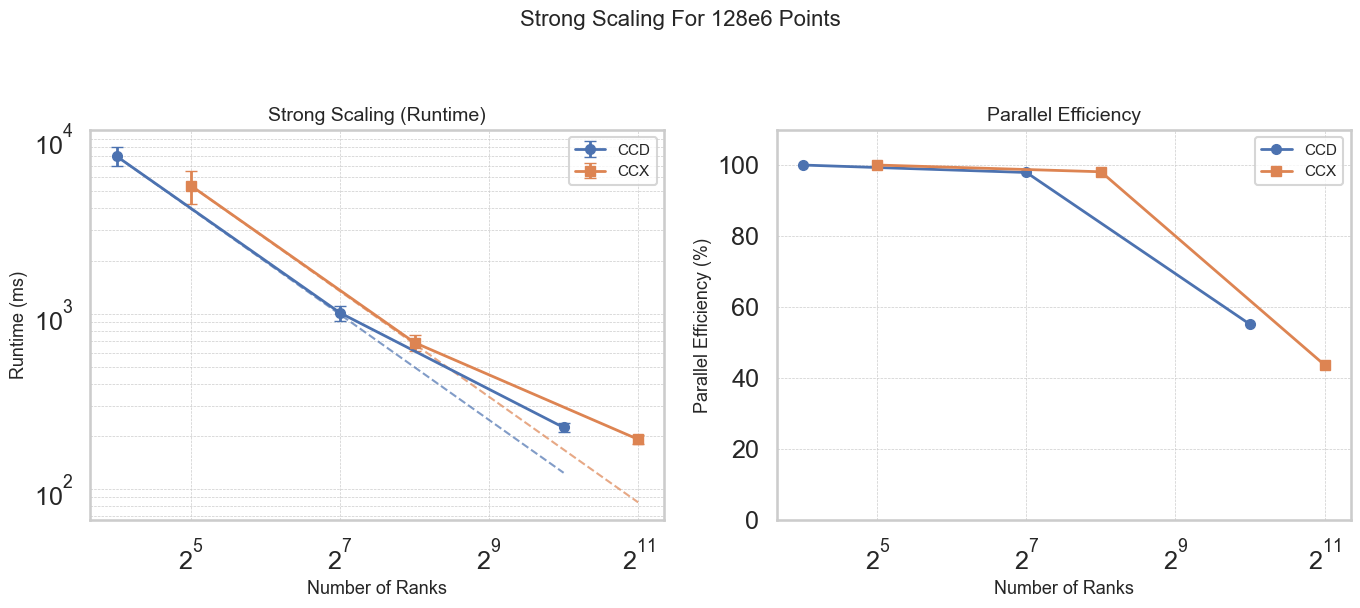

In [7]:
strong_scaling([df0,df1], names=["CCD", "CCX"], title="Strong Scaling For 128e6 Points")